If using google drive please edit this line to connect to drive location

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from google.colab import drive
import os, sys

# Mount the google colab
drive.mount("/content/drive/")
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'DeepLearning_GroupProject/'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
!ls {GOOGLE_DRIVE_PATH}
sys.path.append(GOOGLE_DRIVE_PATH)

# GOOGLE_DRIVE_PATH = '.'


# relative paths
models_dir = 'models'
csv_path = 'Data/updated_data_with_lists.csv'
tensors_dir = 'Data/tensor_batch_notaugmented'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 best_models				  Main.ipynb		      training_12_2_version.ipynb
 best_models_em				  models		      training.ipynb
 Code					  pictures_for_report.pptx    training_jaketesting.ipynb
 Data					 'Project Task List.gsheet'   training_optuna_emily.ipynb
 emily_recipe_checkpoint_12-09_10-17.db   __pycache__		      training_optuna.ipynb
 emily_recipe_checkpoint_12-10_09-48.db   recipe_encoder.py	      training_with_tokens.ipynb
 emily_recipe_checkpoint_12-12_00-24.db   runner_bk.py
'Image Recipe.gdoc'			  runner.py


In [3]:

!pip install optuna

In [4]:

import pandas as pd
from ast import literal_eval
import numpy as np
import torch
import optuna


# Explicitly adding models to the search path
models_path = os.path.join(GOOGLE_DRIVE_PATH, models_dir)
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from models import recipe_encoder

csv_file = os.path.join(GOOGLE_DRIVE_PATH,csv_path)
df = pd.read_csv(csv_file, converters={"Cleaned_Ingredients": literal_eval, "Instructions": literal_eval})
print(len(df))
df.head()

13496


,Unnamed: 0,Title,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[Pat chicken dry with paper towels, season all...",miso-butter-roast-chicken-acorn-squash-panzanella,"[1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher sa..."
1,1,Crispy Salt and Pepper Potatoes,[Preheat oven to 400°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger,"[2 large egg whites, 1 pound new potatoes (abo..."
2,2,Thanksgiving Mac and Cheese,[Place a rack in middle of oven; preheat to 40...,thanksgiving-mac-and-cheese-erick-williams,"[1 cup evaporated milk, 1 cup whole milk, 1 ts..."
3,3,Italian Sausage and Bread Stuffing,[Preheat oven to 350°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559,"[1 (¾- to 1-pound) round Italian loaf, cut int..."
4,4,Newton's Law,[Stir together brown sugar and hot water in a ...,newtons-law-apple-bourbon-cocktail,"[1 teaspoon dark brown sugar, 1 teaspoon hot w..."


Concatenate the batches of preprocessed images into 1 tensor

In [5]:
pt_files = os.listdir(os.path.join(GOOGLE_DRIVE_PATH,tensors_dir))
all_image_tensors = []
all_image_labels = []

# Load and combine all .pt files
for pt_file in pt_files[:5]:
    pt_filepath = os.path.join(GOOGLE_DRIVE_PATH,tensors_dir,pt_file)
    image_tensors, image_labels = torch.load(pt_filepath, weights_only=False)
    all_image_tensors.append(image_tensors)
    all_image_labels.extend(image_labels)
    print(f"Loaded {pt_file}")

# Concatenate tensors
all_image_tensors = torch.cat(all_image_tensors)
print(f"Number of images: {all_image_tensors.size(0)}")
print(f"Number of labels: {len(all_image_labels)}")
assert all_image_tensors.size(0) == len(all_image_labels), "Mismatch between images and labels!"

Loaded batch_0.pt
Loaded batch_1.pt
Loaded batch_2.pt
Loaded batch_3.pt
Loaded batch_4.pt
Number of images: 5000
Number of labels: 5000


Reorganize dataframe to be in the same order as the Image Tensors using the image_label as the matching key

In [6]:
##Reset order of dataframe to match the image labels orders
all_image_labels_cleaned = [label.split(".")[0] for label in all_image_labels] #remove the .png and .jgp
print(all_image_labels_cleaned[:10]) #print to see if at the end the df matches

filtered_df = df[df["Image_Name"].isin(all_image_labels_cleaned)] #filter the df to only have values from the images
print(filtered_df["Image_Name"][:10])
print(df.shape)
print(filtered_df.shape, len(all_image_labels_cleaned))

valid_labels = set(filtered_df['Image_Name'])

# Filter labels and tensors
filtered_labels_and_tensors = [
    (tensor, label) for tensor, label in zip(all_image_tensors, all_image_labels_cleaned) if label in valid_labels
]

# Unpack the filtered data
filtered_tensors, filtered_labels = zip(*filtered_labels_and_tensors)

# Convert back to tensors
filtered_tensors = torch.stack(filtered_tensors)
filtered_labels = list(filtered_labels)

# Verify alignment
print(f"Number of filtered tensors: {len(filtered_tensors)}")
print(f"Number of filtered labels: {len(filtered_labels)}")
print(f"Number of rows in filtered_df: {len(filtered_df)}")

# Finally reorganize the df to be in the same order as the image tensors
filtered_df = filtered_df.set_index("Image_Name").loc[filtered_labels].reset_index()
print(filtered_df["Image_Name"][:10])

['spanish-style-grilled-vegetables-with-breadcrumb-picada-238806', 'three-cheese-pizza-with-onion-sage-and-arugula-233543', 'speedy-skillet-ravioli-lasagna', 'summer-anchovy-salad-51108430', 'spice-roasted-cornish-hens-with-cucumber-yogurt-sauce-353418', 'stovetop-butterscotch-apples-and-cranberries', 'tarte-tatin-51196820', 'spanish-olive-and-cream-cheese-canapes-231160', 'spice-rubbed-sustainable-fish-sliders', 'spiced-pumpkin-layer-cake-240123']
2            thanksgiving-mac-and-cheese-erick-williams
5                  warm-comfort-tequila-chamomile-toddy
7                     turmeric-hot-toddy-claire-sprouse
9        spiced-lentil-and-caramelized-onion-baked-eggs
11          spiral-ham-in-the-slow-cooker-guarnaschelli
19    roasted-beets-with-crispy-sunchokes-and-pickle...
24    sloppy-joe-shirred-eggs-with-spinach-vivian-ho...
27                           spicy-coconut-pumpkin-soup
30                                trinidad-curry-powder
31                                  shrimp-

In [7]:
filtered_df.head()

,Image_Name,Unnamed: 0,Title,Instructions,Cleaned_Ingredients
0,spanish-style-grilled-vegetables-with-breadcru...,10787,Spanish-Style Grilled Vegetables with Breadcru...,[Prepare barbecue (medium heat). Arrange veget...,[3 large red bell peppers (about 1 1/2 pounds)...
1,three-cheese-pizza-with-onion-sage-and-arugula...,12145,"Three-Cheese Pizza with Onion, Sage, and Arugula",[Place pizza stone on floor of gas oven or on ...,[1 (1/4-oz) package active dry yeast (2 1/4 te...
2,speedy-skillet-ravioli-lasagna,551,Speedy Skillet Ravioli Lasagna,[Preheat the oven to 450°F with a rack in the ...,"[2 tbsp. extra-virgin olive oil, 2 large garli..."
3,summer-anchovy-salad-51108430,6117,Summer Anchovy Salad,[Cut tomatoes into fat wedges. Drizzle with ol...,"[Tomatoes, Olive oil, Splash of vinegar, Crumb..."
4,spice-roasted-cornish-hens-with-cucumber-yogur...,8769,Spice-Roasted Cornish Hens with Cucumber-Yogur...,[Position rack in top third of oven; preheat t...,"[3 1 1/4 to 1 1/2-pound Cornish game hens, spl..."


Reformat Ingredients, Recipes, and Image titles

Tokenize Recipes, Ingredients, and Image Titles

In [8]:
from transformers import AutoTokenizer
total_max = 128
# Initialize the tokenizer
tokenizer_recipes = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_nested_list(nested_list, max_length=128):
    """
    Tokenizes a nested list of strings (list of ingredients per recipe).
    Each inner list is tokenized into a list of token IDs.
    """
    tokenized_list = []
    for sublist in nested_list:
        # Join the inner list into a string
        # text = " ".join(sublist)
        text = str(sublist)
        # Tokenize the string
        tokens = tokenizer_recipes(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Append tokenized input_ids to the result list
        tokenized_list.append(tokens["input_ids"].squeeze(0).tolist())
    return tokenized_list

filtered_df['Title_List'] = df['Title'].apply(lambda x: [x])
filtered_df['tokenized_ingredients'] = filtered_df['Cleaned_Ingredients'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_instructions'] = filtered_df['Instructions'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_titles'] = filtered_df['Title_List'].apply(lambda x: tokenize_nested_list(x, total_max))


# # Store tokenized data in a dictionary for your DataLoader
# filtered_df["tokenized_titles"] = title_tokens["input_ids"]
# filtered_df["title_attention_mask"] = title_tokens["attention_mask"]

# filtered_df["tokenized_ingredients"] = ingredients_tokens["input_ids"]
# filtered_df["ingredients_attention_mask"] = ingredients_tokens["attention_mask"]

# filtered_df["tokenized_instructions"] = instructions_tokens["input_ids"]
# filtered_df["instructions_attention_mask"] = instructions_tokens["attention_mask"]
print(len(filtered_df["tokenized_titles"][0]))
print(filtered_df["tokenized_ingredients"][0])
print(filtered_df["tokenized_instructions"][0])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


1
[[101, 1017, 2312, 2417, 4330, 23582, 1006, 2055, 1015, 1015, 1013, 1016, 7038, 1007, 1010, 27674, 1010, 13916, 1010, 4284, 2098, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 2312, 2887, 8288, 24759, 11390, 1006, 2055, 1015, 1015, 1013, 1018, 7038, 1007, 1010, 21920, 1010, 3013, 3091, 14244, 2046, 1017, 25609, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 5396, 2665, 2030, 3756, 16950, 25955, 3490, 1006, 9544, 8231, 1016, 

In [9]:
def pad_or_truncate_nested(sublist, target_length, max_length, pad_token=0):
        """
            Pad or truncate the outer list of a nested list to match the target_length.
            Each inner list remains untouched.
        """
        # Pad with [pad_token] or truncate the outer list
        if len(sublist) < target_length:
            sublist.extend([[pad_token]* max_length] * (target_length - len(sublist)))
        else:
            sublist = sublist[:target_length]
        return sublist

max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()//4
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
filtered_df['tokenized_ingredients'] = filtered_df['tokenized_ingredients'].apply(
    lambda ing: pad_or_truncate_nested(ing, max_length_ing,total_max))

filtered_df['tokenized_instructions'] = filtered_df['tokenized_instructions'].apply(
    lambda inst: pad_or_truncate_nested(inst, max_length_inst, total_max))
# new_token_ing = [pad_or_truncate_nested(ing, max_length_title) for ing in tokenized_ingredients] #titles were all list length of 1
max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
print(max_length_ing, max_length_inst, max_length_title)
print(len(filtered_df['tokenized_ingredients'][5]))
print(filtered_df['tokenized_ingredients'][100])

42 23 1
42
[[101, 1015, 1013, 1018, 2452, 9724, 3514, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 3009, 24444, 1010, 20956, 1998, 4857, 2135, 15920, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 2312, 18856, 21818, 2015, 20548, 1010, 20956, 1998, 24881, 1010, 4606, 1018, 18856, 21818, 2015, 2878, 20548, 1010, 20956, 102, 0, 0, 0, 0, 0, 0, 0,

Tokenize the Image Labels for the Image Encoder

In [10]:
from transformers import AutoTokenizer
from transformers import CLIPModel
model_name = "openai/clip-vit-base-patch16"
clip_model = CLIPModel.from_pretrained(model_name)
tokenizer_images = AutoTokenizer.from_pretrained(model_name)

tokenized_labels = tokenizer_images(
    filtered_labels,
    padding="max_length",
    truncation=True,
    max_length=tokenizer_images.model_max_length,
    return_tensors="pt"
)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
%reload_ext autoreload


cuda:0


In [12]:
import torch.nn as nn
class RecipeDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(RecipeDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, input_tokens):
        embedded = self.embedding(input_tokens)
        outputs, hidden_state = self.rnn(embedded, hidden_state)
        predictions = self.fc_out(outputs)
        return predictions

In [13]:
def calc_recall_1(top, image_features, recipe_embeddings, image_labels):
  true_pos = 0
  false_neg = 0
  tmp_batches = image_features.shape[0]
  # print(image_features.shape, recipe_embeddings.shape)
  for i in range(tmp_batches):
    cosine_similarity = torch.nn.CosineSimilarity(dim=1)
    similarities = cosine_similarity(image_features[i, :].unsqueeze(0), recipe_embeddings)
    # print(similarities)
    #top = amount of top results to retrieve
    top_results = top
    top_k_values, top_k_indices = torch.topk(similarities, top_results, largest=True)
    # print(top_k_values, top_k_indices)
    top_k_indices = top_k_indices.cpu().numpy().tolist()
    top_images = [(filtered_df['Image_Name'][i]) for i in top_k_indices]
    if image_labels[i] in [image for image in top_images]:
      true_pos += 1
    else:
      false_neg += 1

  return (true_pos / tmp_batches)


def calc_recall(top, image_features, recipe_embeddings, image_ind):
  # print('size of image features', image_features.shape)
  true_pos = 0
  false_neg = 0
  tmp_batches = image_features.shape[0]
  image_features = torch.nn.functional.normalize(image_features, dim=1)
  recipe_embeddings = torch.nn.functional.normalize(recipe_embeddings, dim=1)
  top_embedded = []

  for i in range(tmp_batches):
    cosine_similarity = torch.nn.CosineSimilarity(dim=1)
    similarities = cosine_similarity(image_features[i,:], recipe_embeddings)
    top_results = top
    top_k_values, top_k_indices = torch.topk(similarities, top_results, largest=True)
    top_k_indices = top_k_indices.tolist()
    # print(top_k_indices)
    if i in top_k_indices:
      # print(f"found index {i} in {top_k_indices}")
      true_pos += 1
    else:
      false_neg += 1

    # print('-----------')
  # print("total found = ", ((true_pos / tmp_batches) * 100), "%")
  return true_pos / tmp_batches


In [25]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from models.image_2_recipe import Image2Recipe
from models.image_encoder import Image_Encoder
from models.recipe_encoder import RecipeEncoder
from models.MMR import MMR
from models.MMR import MMR_losses
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime


class Data_Loading(Dataset):
    """
    Class to combine the Images, Labels, Recipes together to be used in combination when inputted into Model
    """
    def __init__(self, tokenized_ingredients, tokenized_instructions, tokenized_titles, image_tensors, image_labels):
        self.ingredients = torch.tensor(tokenized_ingredients, dtype=torch.int16)
        self.instructions = torch.tensor(tokenized_instructions, dtype=torch.int16)
        self.titles = torch.tensor(tokenized_titles, dtype=torch.int16)
        self.images = image_tensors
        self.image_labels = image_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "ingredients": self.ingredients[idx],
            "instructions": self.instructions[idx],
            "titles": self.titles[idx],
            "images": self.images[idx],
            "image_labels": self.image_labels[idx]
            # "tokenized_labels": {
            #     "input_ids": self.tokenized_labels['input_ids'][idx].to(dtype=torch.long),
            #     "attention_mask": self.tokenized_labels['attention_mask'][idx].to(dtype=torch.uint8)
            # }
        }



class Trainer(object):
    """
    Class designed to run ViT (train, evaluate, plot)
    """

    def __init__(self, **kwargs):
        """
        Initialize ViT
        """
        self.params = kwargs
        self.trial = kwargs['trial']
        self.best_trial_loss = kwargs['best_trial_loss']
        self.epochs = kwargs['epochs']
        self.optimizer_name = kwargs['optimizer']
        self.device = kwargs['device']
        self.batch_size = kwargs['batch_size']
        self.lr = kwargs['learning_rate']

        self.tokenized_ingredients = kwargs['ingredient_tokens']
        self.tokenized_instructions = kwargs['instruction_tokens']
        self.tokenized_title = kwargs['title_tokens']
        self.image_tensor = kwargs['image_tensors']
        self.image_labels = kwargs['image_labels']
        self.clip_model = kwargs['clip_model']
        self.vocab_size = kwargs['vocab_size']
        self.max_len = kwargs['max_len']
        self.instance_weight = kwargs['instance_weight']
        self.sem_weight = kwargs['sem_weight']
        self.itm_weight = kwargs['itm_weight']
        self.best_model_parameters = kwargs['best_model_parameters_path']
        self.initial_margin = kwargs['initial_margin']
        self.margin_step = kwargs['margin_step']
        self.max_margin = kwargs['max_margin']
        self.topk = kwargs['topk']
        self.fixed_margin = kwargs['fixed_margin']
        self.improvement_threshold = kwargs['improvement_threshold']
        self.patience = kwargs['patience']
        self.best_model_parameters = kwargs['best_model_parameters_path']
        mode = 'optuna'

        self.mmr_heads = kwargs['mmr_heads']
        self.ITEM_lyrs = kwargs['ITEM_lyrs']
        self.MTD_lyrs = self.ITEM_lyrs
        self.hidden_dim = kwargs['hidden_dim']
        # self.recipe_enc_hidden = kwargs['recipe_enc_hidden']
        self.projection_dim=kwargs['projection_dim']
        self.MMR_type = kwargs['MMR_type']
        self.recall_weight = kwargs['recall_weight']
        self.loss_calcs = MMR_losses(instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        num_classes = len(set(self.image_labels))



        self.image_encoder = Image_Encoder(self.device, self.clip_model, num_classes).to(self.device)
        # self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len, hidden_dim=self.recipe_enc_hidden).to(self.device)
        self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len, hidden_dim=self.hidden_dim).to(self.device)
        self.mmr = MMR(hidden_dim=self.image_encoder.clip_model.config.projection_dim, num_heads=self.mmr_heads, ITEM_lyrs=self.ITEM_lyrs, MTD_lyrs=self.MTD_lyrs, projection_dim=self.projection_dim, MMR_type=self.MMR_type).to(self.device)


        # MMR varaibles: num_heads=num_heads, ITEM_lyrs=ITEM_lyrs, MTD_lyrs=MTD_lyrs, projection_dim=projection_dim,  MMR_type="type_separate")
        self.model = Image2Recipe(self.image_encoder, self.recipe_encoder, self.mmr).to(self.device)

        ##DO we want to tune each of these learning rates for each model?
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        #Combine Images, Recipes, Instructions in training and eval datasets
        self.data_total = Data_Loading(
            self.tokenized_ingredients,
            self.tokenized_instructions,
            self.tokenized_title,
            self.image_tensor,
            self.image_labels
        )
        training_perc = 0.7
        train_size = int(training_perc * len(self.data_total))
        eval_size = len(self.data_total) - train_size
        train_dataset, eval_dataset = random_split(self.data_total, [train_size, eval_size])
        self.dataloader = {}
        self.dataloader['train'] = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.dataloader['eval'] = DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

        #Lists to fill up during training and plotted later for learning curves
        self.train_loss_list = []
        self.train_loss_actual_list = []
        self.eval_loss_list = []
        self.eval_acc_list = []
        self.eval_acc_list = []
        self.best_score = 0
        self.best_loss = 1000
        print("finished initializing")

        # self.CELoss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        # self.decoder_lambda = kwargs['decoder_lambda']

    def train(self, trial=None):
        """
        Train ViT, image encoder, recipe encoder, MMR
        """
        # Set initial margin
        mode = 'optuna'
        self.margin = self.initial_margin
        patience_count = 0
        early_stop = False
        recall_weight = self.recall_weight

        for param in self.model.image_encoder.parameters():
            param.requires_grad = False

        for epoch in range(self.epochs):
            if epoch == 5:
              for param in self.model.image_encoder.parameters():
                  param.requires_grad = True
              print("unfreezing image encoder")
              self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

            if early_stop == True:
              if mode == 'optuna':
                return (self.best_loss, self.train_loss_actual_list[-1])
              break
            for phase in ['eval', 'train']:
                if early_stop == True:
                    break
                total_loss = 0
                total_loss_actual = 0
                total_accuracy = 0
                total_eval_loss = 0
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                j = 0  # limit print statements
                for i, batch_data in enumerate(tqdm(self.dataloader[phase],position=0, leave=True)):
                    #Looping through batches of training data then eval data each epoch
                    #TODO: Add how the recipe, instructions, and titles will be tokenized
                    ingredients, instructions, titles, images, image_labels = (
                        batch_data['ingredients'].to(self.device),
                        batch_data['instructions'].to(self.device),
                        batch_data['titles'].to(self.device),
                        batch_data['images'].to(self.device),
                        batch_data['image_labels']
                    )

                    recipe_enc_src = [titles, ingredients, instructions]
                    self.optimizer.zero_grad()

                    if phase == 'train':
                        output = self.model(images, image_labels, recipe_enc_src)
                        ##Combine the Recipe Encoder Losses and Image Encoder Losses based on TFOOD
                        mmr_logits = output["mmr_logits"]
                        image_logits = output["image_logits"]
                        image_embeddings_proj = output["image_embeddings_proj"]
                        recipe_embeddings_proj = output["recipe_embeddings_proj"]
                        image_ind = np.arange(0, image_embeddings_proj.shape[0])
                        # image_embeddings = output["image_embeddings"]
                        # recipe_embeddings = output["recipe_embeddings"]

                        # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                        # title_logits = self.recipe_decoder(image_embeddings, titles)
                        # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                        # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                        # #Compute Reconstruction Loss
                        # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                        # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                        # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                        # decoder_loss = (title_loss + ingredients_loss + instructions_loss) *self.decoder_lambda
                        # Get a value for the fixed loss to get a nice loss curve
                        #if epoch % 10 == 0:
                        # comparison_loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                        #                                  recipe_embeddings_proj, mmr_logits, margin=self.fixed_margin, printout=True)

                        comparison_loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, margin=self.fixed_margin)
                        image_ind = np.arange(0, image_embeddings_proj.shape[0])

                        loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, margin=self.margin)
                        if recall_weight > 0:
                          loss = loss * (1/(calc_recall(3, image_embeddings_proj, recipe_embeddings_proj, image_ind) + 1e-3)) * recall_weight
                          comparison_loss = comparison_loss * (1/(calc_recall(3, image_embeddings_proj, recipe_embeddings_proj, image_ind) + 1e-3)) * recall_weight

                        if j%100 == 0:
                          print(f'training loss for step: {loss.item()}')
                          # print(image_ind
                          recall_score_2 = calc_recall(2, image_embeddings_proj, recipe_embeddings_proj, image_ind)
                          recall_score_5 = calc_recall(5, image_embeddings_proj, recipe_embeddings_proj, image_ind)
                          recall_score_10 = calc_recall(10, image_embeddings_proj, recipe_embeddings_proj, image_ind)

                          print(f'train recall score in 2 is {recall_score_2}')
                          print(f'train recall score in 5 is {recall_score_5}')
                          print(f'train recall score in 10 is {recall_score_10}')
                        j += 1
                        # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                        # print(recall_score)

                        total_loss += comparison_loss.item()
                        total_loss_actual += loss.item()

                        loss.backward()
                        self.optimizer.step()
                        # self.optimizer2.step() #decoder optimizer

                    else: ##Eval mode
                        with torch.no_grad():
                            output = self.model(images, image_labels, recipe_enc_src)
                            mmr_logits = output["mmr_logits"]
                            image_logits = output["image_logits"]
                            image_embeddings_proj = output["image_embeddings_proj"]
                            recipe_embeddings_proj = output["recipe_embeddings_proj"]
                            image_ind = np.arange(0, image_embeddings_proj.shape[0])
                            # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                            # title_logits = self.recipe_decoder(image_embeddings, titles)
                            # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                            # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                            # #Compute Reconstruction Loss
                            # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                            # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                            # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                            # decoder_loss = (title_loss + ingredients_loss + instructions_loss) * self.decoder_lambda
                            # eval loss has a fixed margin because we want the best model
                            eval_loss = self.loss_calcs.total_eval_loss(image_logits, image_embeddings_proj,
                                                                   recipe_embeddings_proj, margin=self.fixed_margin)  # + decoder_loss
                            if recall_weight > 0:
                              eval_loss = eval_loss * (1/(calc_recall(3, image_embeddings_proj, recipe_embeddings_proj, image_ind)+ 1e-3)) * recall_weight

                            total_eval_loss += eval_loss.item()

                            if j%50 == 0:
                              image_ind = np.arange(0, image_embeddings_proj.shape[0])
                              sem_loss = self.loss_calcs.instance_semantic_loss(image_embeddings_proj, recipe_embeddings_proj, image_logits, margin=self.fixed_margin, mode='semantic')
                              inst_loss = self.loss_calcs.instance_semantic_loss(image_embeddings_proj, recipe_embeddings_proj, image_logits, margin=self.fixed_margin, mode='instance')
                              recall_score_2 = calc_recall(2, image_embeddings_proj, recipe_embeddings_proj, image_ind)
                              recall_score_5 = calc_recall(5, image_embeddings_proj, recipe_embeddings_proj, image_ind)
                              recall_score_10 = calc_recall(10, image_embeddings_proj, recipe_embeddings_proj, image_ind)

                              print(f'eval recall score in 2 is {recall_score_2}')
                              print(f'eval recall score in 5 is {recall_score_5}')
                              print(f'eval recall score in 10 is {recall_score_10}')


                              #print(f'sem_loss for eval step: {sem_loss.item()}')
                              #print(f'inst_loss for eval step: {inst_loss.item()}')
                            j += 1
                            # self.eval_loss_list.append(loss.item())

                            # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                            # print(recall_score)


                    # del unused_tensor
                    torch.cuda.empty_cache() #clear cache after each batch
                    # print(i)
                    # print(output)



                # print(f"{phase}: Epoch {epoch+1}, Loss: {total_loss / len(self.dataloader[phase])}")

                # Update loss margin
                # print(f"Epoch {epoch+1}, Eval loss: {total_eval_loss / len(self.dataloader[phase])}")

                if self.margin <= (self.max_margin - self.margin_step):
                    self.margin += self.margin_step
                else:
                    self.margin = self.max_margin
                if phase == "train":
                  print(f"Epoch {epoch+1}, Loss: {total_loss / len(self.dataloader[phase])}")
                  self.train_loss_list.append(total_loss/len(self.dataloader[phase]))
                  self.train_loss_actual_list.append(total_loss_actual/len(self.dataloader[phase]))
                  # Check if optuna's training trial should continue
                  epoch_loss = total_loss_actual
                  if trial:
                    trial.report(epoch_loss, epoch)
                    if trial.should_prune():
                      raise optuna.exceptions.TrialPruned()
                else:
                  print(f"Epoch {epoch+1}, Eval loss: {total_eval_loss / len(self.dataloader[phase])}")
                  total_eval_loss = total_eval_loss / len(self.dataloader[phase])
                  self.eval_loss_list.append(total_eval_loss)

                  if (self.best_loss - total_eval_loss) > self.improvement_threshold:
                    print(f"{total_eval_loss} is < {self.best_loss}, saving best model")
                    torch.save(self.model.state_dict(), f"/content/drive/My Drive/DeepLearning_GroupProject/best_models_em/best_model_{trial}_emily.pth")

                    patience_count = 0
                    self.best_loss = total_eval_loss
                    # torch.save(self.model.state_dict(), self.best_model_parameters)
                  else:
                    patience_count += 1
                    print(f"{total_eval_loss} is not < {self.best_loss}, patience is at {patience_count} of {self.patience}")
                    if patience_count >= self.patience:
                      print("Early stopping")
                      early_stop = True
                      self.stop_epoch = epoch
                  if mode == 'optuna':
                    if epoch > 4:
                      if self.best_loss > (self.best_trial_loss * 2):
                         print(f'prining this trial: {self.trial}')
                         early_stop = True
                         self.stop_epoch = epoch
        self.stop_epoch = epoch
        if mode == 'optuna':
          return (self.best_loss, self.train_loss_actual_list[-1])

    def save_training_results(self):
        data = {
            'Parameter': list(self.params.keys()),
            'Value': list(self.params.values()),
            'Best Loss': self.best_loss,
            'Training loss': self.train_loss_list[-1],
            'Epochs': self.stop_epoch
        }
        df = pd.DataFrame(data)

        save_path = f'/content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_{self.trial}.csv'

        df.to_csv(save_path, mode='a', header=False, index=False)
        print(f"Training results saved to {save_path}")

    ##Waiting on training code to finish
    def plot_learning_loss_curves(self):
        """
        Plot accuracy and loss curves for training and eval accuracy/loss lists (item/epoch)
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_loss_list, label='Training Loss')
        plt.plot(self.eval_loss_list, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.savefig(f'/content/drive/My Drive/DeepLearning_GroupProject/best_models_em/{self.trial}_loss_curve.png')
        plt.show()

        # plt.figure(figsize=(10, 5))
        # plt.plot(self.train_acc_list, label='Training Accuracy')
        # plt.plot(self.eval_acc_list, label='Validation Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('Accuracy Curve')
        # plt.legend()
        # plt.show()


In [19]:
%autoreload 2

In [20]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


2.5.1+cu121
True
finished initializing


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.3
eval recall score in 10 is 1.0
Epoch 1, Eval loss: 425.7597308830927
425.7597308830927 is < 1000, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 12.016629219055176
train recall score in 2 is 0.3
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 20.724517822265625
train recall score in 2 is 0.3
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 13.869019508361816
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 9.219459533691406
train recall score in 2 is 0.3
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 1, Loss: 263.67541766647645


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.3
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.7
eval recall score in 10 is 1.0
Epoch 2, Eval loss: 378.16713909174774
378.16713909174774 is < 425.7597308830927, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 29.978281021118164
train recall score in 2 is 0.1
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 38.200016021728516
train recall score in 2 is 0.3
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 85.87077331542969
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 56.692195892333984
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 2, Loss: 134.76534584551104


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 3, Eval loss: 432.11288526394225
432.11288526394225 is not < 378.16713909174774, patience is at 1 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 43.74281311035156
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 72.2596664428711
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 112.19161987304688
train recall score in 2 is 0.0
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 39.608585357666016
train recall score in 2 is 0.3
train recall score in 5 is 0.4
train recall score in 10 is 1.0
Epoch 3, Loss: 138.1235553950329


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 4, Eval loss: 427.25477456726486
427.25477456726486 is not < 378.16713909174774, patience is at 2 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 109.70891571044922
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 29.942380905151367
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 98.60474395751953
train recall score in 2 is 0.1
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 56.49819564819336
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 4, Loss: 135.46841938557475


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 5, Eval loss: 149.12838704153995
149.12838704153995 is < 378.16713909174774, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 59.69572830200195
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 97.36183166503906
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 88.32816314697266
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 137.2137908935547
train recall score in 2 is 0.2
train recall score in 5 is 0.3
train recall score in 10 is 1.0
Epoch 5, Loss: 141.3950699907902
unfreezing image encoder


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.7
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
Epoch 6, Eval loss: 413.14047666204056
413.14047666204056 is not < 149.12838704153995, patience is at 1 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 69.14643096923828
train recall score in 2 is 0.1
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 82.56819152832031
train recall score in 2 is 0.3
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 268.6942443847656
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 104.10966491699219
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 6, Loss: 231.4392867404377


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 7, Eval loss: 422.6870336084558
422.6870336084558 is not < 149.12838704153995, patience is at 2 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 65.83319854736328
train recall score in 2 is 0.3
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 72.18144226074219
train recall score in 2 is 0.1
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 322.1899719238281
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 65.22785186767578
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 7, Loss: 221.625906501792


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.3
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 8, Eval loss: 134.56516255628344
134.56516255628344 is < 149.12838704153995, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 58.876888275146484
train recall score in 2 is 0.3
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 34.673370361328125
train recall score in 2 is 0.3
train recall score in 5 is 0.8
train recall score in 10 is 1.0
training loss for step: 164.67254638671875
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 160.5390625
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 8, Loss: 394.889895810174


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 9, Eval loss: 573.3345838969186
573.3345838969186 is not < 134.56516255628344, patience is at 1 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 134.38880920410156
train recall score in 2 is 0.3
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 61.033119201660156
train recall score in 2 is 0.3
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 100.14024353027344
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 87.44125366210938
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 9, Loss: 197.49041997596234


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.0
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 10, Eval loss: 375.4117119808325
375.4117119808325 is not < 134.56516255628344, patience is at 2 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 140.61192321777344
train recall score in 2 is 0.0
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 83.65097045898438
train recall score in 2 is 0.3
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 123.15613555908203
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 100.35740661621094
train recall score in 2 is 0.2
train recall score in 5 is 0.7
train recall score in 10 is 1.0
Epoch 10, Loss: 406.7780111076509


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.7
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 11, Eval loss: 120.6915885874089
120.6915885874089 is < 134.56516255628344, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 147.73971557617188
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 186.78453063964844
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 447.9174499511719
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 52505.56640625
train recall score in 2 is 0.0
train recall score in 5 is 0.3
train recall score in 10 is 1.0
Epoch 11, Loss: 432.6719082879058


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
Epoch 12, Eval loss: 128.965747730844
128.965747730844 is not < 120.6915885874089, patience is at 1 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 527.5497436523438
train recall score in 2 is 0.1
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 126.56887817382812
train recall score in 2 is 0.3
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 60.02281188964844
train recall score in 2 is 0.4
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 166.45272827148438
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
Epoch 12, Loss: 497.0718799887885


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 13, Eval loss: 126.72912062574554
126.72912062574554 is not < 120.6915885874089, patience is at 2 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 166.43450927734375
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 82.29771423339844
train recall score in 2 is 0.5
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 212.8284454345703
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 168.3756866455078
train recall score in 2 is 0.1
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 13, Loss: 181.65310420495288


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.4
eval recall score in 5 is 0.7
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 14, Eval loss: 307.4615098069978
307.4615098069978 is not < 120.6915885874089, patience is at 3 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 296.5159912109375
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 196.22731018066406
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 131.61505126953125
train recall score in 2 is 0.1
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 122.18684387207031
train recall score in 2 is 0.3
train recall score in 5 is 0.7
train recall score in 10 is 1.0
Epoch 14, Loss: 339.6156816949762


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.0
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 15, Eval loss: 263.7122474900828
263.7122474900828 is not < 120.6915885874089, patience is at 4 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 193.04428100585938
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 57327.953125
train recall score in 2 is 0.0
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 272.4471130371094
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 119.44391632080078
train recall score in 2 is 0.3
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 15, Loss: 430.4640617590473


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.3
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
Epoch 16, Eval loss: 346.1834389347358
346.1834389347358 is not < 120.6915885874089, patience is at 5 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 310.7379455566406
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 220.25962829589844
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 331.9837951660156
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 87.71859741210938
train recall score in 2 is 0.4
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 16, Loss: 160.7902174738024


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.0
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 17, Eval loss: 316.04480376019575
316.04480376019575 is not < 120.6915885874089, patience is at 6 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 311.951904296875
train recall score in 2 is 0.1
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 367.712646484375
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 166.7445831298828
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 196.55104064941406
train recall score in 2 is 0.3
train recall score in 5 is 0.4
train recall score in 10 is 1.0
Epoch 17, Loss: 385.70916696378066


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.2
eval recall score in 10 is 1.0
Epoch 18, Eval loss: 483.222318738899
483.222318738899 is not < 120.6915885874089, patience is at 7 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 151.3433380126953
train recall score in 2 is 0.3
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 359.2423400878906
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 245.05975341796875
train recall score in 2 is 0.2
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 129.60130310058594
train recall score in 2 is 0.4
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 18, Loss: 577.7837421131409


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 19, Eval loss: 88.88877648475186
88.88877648475186 is < 120.6915885874089, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 208.4680938720703
train recall score in 2 is 0.1
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 188.84466552734375
train recall score in 2 is 0.3
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 387.4355773925781
train recall score in 2 is 0.0
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 149.2504425048828
train recall score in 2 is 0.5
train recall score in 5 is 0.7
train recall score in 10 is 1.0
Epoch 19, Loss: 291.42302243785144


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.0
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.4
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.4
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
Epoch 20, Eval loss: 249.12679335574975
249.12679335574975 is not < 88.88877648475186, patience is at 1 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 194.0533447265625
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 218.16770935058594
train recall score in 2 is 0.3
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 685.027099609375
train recall score in 2 is 0.0
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 222.89620971679688
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 20, Loss: 193.3842426486936


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.7
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
Epoch 21, Eval loss: 577.8804321161052
577.8804321161052 is not < 88.88877648475186, patience is at 2 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 204.11875915527344
train recall score in 2 is 0.3
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 138.09031677246094
train recall score in 2 is 0.2
train recall score in 5 is 0.8
train recall score in 10 is 1.0
training loss for step: 186.52978515625
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 247.0277862548828
train recall score in 2 is 0.0
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 21, Loss: 177.69049156914528


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.2
eval recall score in 10 is 1.0
Epoch 22, Eval loss: 394.22201384473965
394.22201384473965 is not < 88.88877648475186, patience is at 3 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 275.3902282714844
train recall score in 2 is 0.3
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 223.67933654785156
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 674.2958984375
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 118.99385833740234
train recall score in 2 is 0.3
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 22, Loss: 424.28547560722063


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 23, Eval loss: 350.3834686919347
350.3834686919347 is not < 88.88877648475186, patience is at 4 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 250.48443603515625
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 816.5380249023438
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 385.2268371582031
train recall score in 2 is 0.2
train recall score in 5 is 0.2
train recall score in 10 is 1.0
training loss for step: 221.26402282714844
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 23, Loss: 537.7344148234606


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.4
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 24, Eval loss: 231.07351564240935
231.07351564240935 is not < 88.88877648475186, patience is at 5 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 743.6306762695312
train recall score in 2 is 0.0
train recall score in 5 is 0.2
train recall score in 10 is 1.0
training loss for step: 333.5794982910156
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 178.0962677001953
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 218.79879760742188
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 24, Loss: 201.5525413919938


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.4
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.4
eval recall score in 5 is 0.8
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 25, Eval loss: 405.13602717610814
405.13602717610814 is not < 88.88877648475186, patience is at 6 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 423.5581359863281
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 231.83172607421875
train recall score in 2 is 0.2
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 182.9702911376953
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 248.1185302734375
train recall score in 2 is 0.2
train recall score in 5 is 0.5
train recall score in 10 is 1.0
Epoch 25, Loss: 489.4533196539975


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 26, Eval loss: 207.1825917007139
207.1825917007139 is not < 88.88877648475186, patience is at 7 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 263.7286071777344
train recall score in 2 is 0.1
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 260.0672302246094
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 400.8309326171875
train recall score in 2 is 0.0
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 302.71893310546875
train recall score in 2 is 0.1
train recall score in 5 is 0.3
train recall score in 10 is 1.0
Epoch 26, Loss: 470.69155810133526


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.4
eval recall score in 5 is 0.7
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 27, Eval loss: 444.5100848178736
444.5100848178736 is not < 88.88877648475186, patience is at 8 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 276.7177734375
train recall score in 2 is 0.1
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 277.0765075683594
train recall score in 2 is 0.1
train recall score in 5 is 0.7
train recall score in 10 is 1.0
training loss for step: 421.9454040527344
train recall score in 2 is 0.1
train recall score in 5 is 0.3
train recall score in 10 is 1.0
training loss for step: 207.5555877685547
train recall score in 2 is 0.3
train recall score in 5 is 0.6
train recall score in 10 is 1.0
Epoch 27, Loss: 204.17570261446818


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.3
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.0
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
Epoch 28, Eval loss: 303.2856813981229
303.2856813981229 is not < 88.88877648475186, patience is at 9 of 10


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 281.59857177734375
train recall score in 2 is 0.3
train recall score in 5 is 0.5
train recall score in 10 is 1.0
training loss for step: 445.58502197265625
train recall score in 2 is 0.0
train recall score in 5 is 0.4
train recall score in 10 is 1.0
training loss for step: 440.7568054199219
train recall score in 2 is 0.2
train recall score in 5 is 0.6
train recall score in 10 is 1.0
training loss for step: 444.80133056640625
train recall score in 2 is 0.1
train recall score in 5 is 0.3
train recall score in 10 is 1.0
Epoch 28, Loss: 607.4193071920521


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.0
eval recall score in 5 is 0.2
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
eval recall score in 2 is 0.1
eval recall score in 5 is 0.4
eval recall score in 10 is 1.0
Epoch 29, Eval loss: 243.20031340170226
243.20031340170226 is not < 88.88877648475186, patience is at 10 of 10
Early stopping


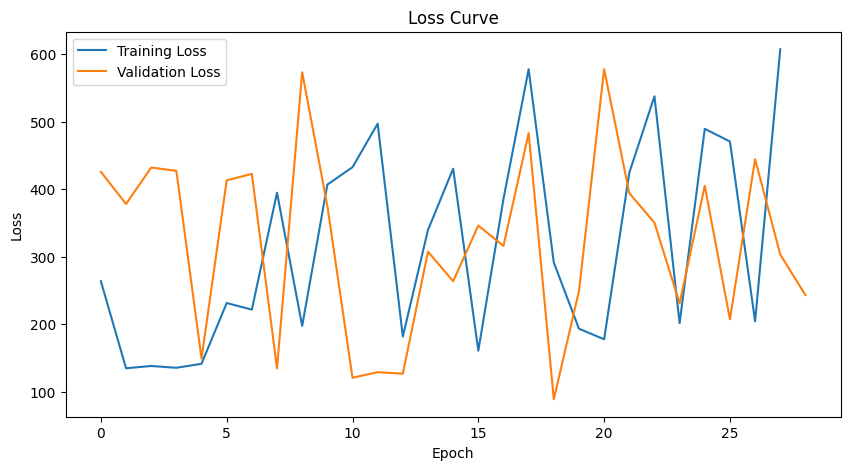

Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_0.csv
new best trial # 0 has best eval loss 88.88877648475186 and train loss 2953.20230909452


In [26]:
# Cuda issues
# Manual bc optuna can't be done here
best_trial_loss = 1000000000
trials = {'mmr_heads': [8], 'ITEM_lyrs': [1], 'projection_dim': [64], 'MMR_type': ['type_shared'] }

for trial in range(len(trials['mmr_heads'])):
  print(torch.__version__)
  print(torch.cuda.is_available())
  vocab_size = tokenizer_recipes.vocab_size
  param_path = os.path.join(GOOGLE_DRIVE_PATH, f"best_models_em/best_model_{trial}_emily.pth")
  recipe_embeddings_path  = os.path.join(GOOGLE_DRIVE_PATH, "best_models_em/recipe_embeddings.pth")

  kwargs = {
    'trial' : trial,
    'best_trial_loss' : best_trial_loss,
    'epochs': 75,
    'ingredient_tokens': filtered_df['tokenized_ingredients'].to_list(),
    'instruction_tokens': filtered_df['tokenized_instructions'].to_list(),
    'title_tokens': filtered_df['tokenized_titles'].to_list(),
    'image_tensors': filtered_tensors,
    'image_labels': filtered_df['Image_Name'],
    'device': device,
    'vocab_size': vocab_size,
    'max_len': total_max,
    'clip_model': clip_model,
    'optimizer': 'adam',
    'learning_rate': 1e-7,
    'batch_size': 10,
    'instance_weight': 1,
    'sem_weight': 5,
    'itm_weight': 0.5,
    'initial_margin': 5.0,
    'margin_step': 1,
    'max_margin': 1000.0,
    'best_model_parameters_path': param_path,
    'decoder_lambda': 0.1,
    'topk': 10,
    'patience': 10,
    'improvement_threshold': 0.0001,
    'projection_dim': trials['projection_dim'][trial],
    'fixed_margin': 20,
    'hidden_dim' : 512, #trials['hidden_dim'][trial],
    'mmr_heads': trials['mmr_heads'][trial],
    'ITEM_lyrs': trials['ITEM_lyrs'][trial],
    'MTD_lyrs': 1,
    'MMR_type': trials['MMR_type'][trial],
    'recall_weight': 1
    }
  image2recipe = Trainer(**kwargs)
  final_loss = image2recipe.train()
  image2recipe.plot_learning_loss_curves()
  image2recipe.save_training_results()
  if final_loss[0] < best_trial_loss:
    best_trial_loss = final_loss[0]
    torch.save(image2recipe.model.state_dict(), param_path)
    print(f'new best trial # {trial} has best eval loss {best_trial_loss} and train loss {final_loss[1]}')

In [22]:
# Cuda issues
# Manual bc optuna can't be done here
best_trial_loss = 1000000000
trials = {'mmr_heads': [2], 'ITEM_lyrs': [1], 'projection_dim': [128], 'MMR_type': ['type_separate'] }

for trial in range(len(trials['mmr_heads'])):
  print(torch.__version__)
  print(torch.cuda.is_available())
  vocab_size = tokenizer_recipes.vocab_size
  param_path = os.path.join(GOOGLE_DRIVE_PATH, f"best_models_em/best_model_{trial}_emily.pth")
  recipe_embeddings_path  = os.path.join(GOOGLE_DRIVE_PATH, "best_models_em/recipe_embeddings.pth")

  kwargs = {
    'trial' : trial,
    'best_trial_loss' : best_trial_loss,
    'epochs': 75,
    'ingredient_tokens': filtered_df['tokenized_ingredients'].to_list(),
    'instruction_tokens': filtered_df['tokenized_instructions'].to_list(),
    'title_tokens': filtered_df['tokenized_titles'].to_list(),
    'image_tensors': filtered_tensors,
    'image_labels': filtered_df['Image_Name'],
    'device': device,
    'vocab_size': vocab_size,
    'max_len': total_max,
    'clip_model': clip_model,
    'optimizer': 'adam',
    'learning_rate': 1e-7,
    'batch_size': 10,
    'instance_weight': 1,
    'sem_weight': 5,
    'itm_weight': 0.5,
    'initial_margin': 5.0,
    'margin_step': 1,
    'max_margin': 1000.0,
    'best_model_parameters_path': param_path,
    'decoder_lambda': 0.1,
    'topk': 10,
    'patience': 10,
    'improvement_threshold': 0.0001,
    'projection_dim': trials['projection_dim'][trial],
    'fixed_margin': 20,
    'hidden_dim' : 512, #trials['hidden_dim'][trial],
    'mmr_heads': trials['mmr_heads'][trial],
    'ITEM_lyrs': trials['ITEM_lyrs'][trial],
    'MTD_lyrs': 1,
    'MMR_type': trials['MMR_type'][trial],
    'recall_weight': 1
    }
  image2recipe = Trainer(**kwargs)
  final_loss = image2recipe.train()
  image2recipe.plot_learning_loss_curves()
  image2recipe.save_training_results()
  if final_loss[0] < best_trial_loss:
    best_trial_loss = final_loss[0]
    torch.save(image2recipe.model.state_dict(), param_path)
    print(f'new best trial # {trial} has best eval loss {best_trial_loss} and train loss {final_loss[1]}')

2.5.1+cu121
True
finished initializing


  0%|          | 0/149 [00:00<?, ?it/s]

eval recall score in 2 is 0.2
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.0
eval recall score in 5 is 0.5
eval recall score in 10 is 1.0
eval recall score in 2 is 0.3
eval recall score in 5 is 0.6
eval recall score in 10 is 1.0
Epoch 1, Eval loss: 146.17436505004065
146.17436505004065 is < 1000, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

NameError: name 'recall_weigh' is not defined

trials = {'mmr_heads': [2, 2, 2, 4, 4, 4, 8, 8, 8], 'ITEM_lyrs': [2, 2, 6, 2, 2, 6, 2, 2, 6], 'projection_dim': [256, 512, 256, 256, 512, 256], 'MMR_type': ['type_separate', 'type_shared', 'type_separate', 'type_shared', 'type_separate', 'type_shared'] }


Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_5.csv
new best trial # 5 has best eval loss 20.55053238580691 and train loss 60.407340486729865
2.5.1+cu121
True 11 ealy stop


Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_0.csv
new best trial # 0 has best eval loss 20.277718153575922 and train loss 51.70182333075004
2.5.1+cu121 epich 11



new best trial # 1 has best eval loss 20.13494167711911 and train loss 53.90035104339336
2.5.1+cu121 epoch 12


Epoch 10, Loss: 45.34060494150827
100%

 trial #2 Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_2.csv
new best trial # 2 has best eval loss 20.3040890981687 and train loss 60.474554518114246
2.5.1+cu121






In [ ]:
###Plot in tSNE to debug
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_2D(recipe_embeddings, image_embeddings):
  batches = image_embeddings.shape[0]
  recipe_embeddings = recipe_embeddings.detach().cpu().numpy()
  image_embeddings = image_embeddings.detach().cpu().numpy()
  combined_embeddings = np.concatenate((recipe_embeddings, image_embeddings), axis=0)
  plt.figure(figsize=(8, 8))
  for batch in range(batches):
    plt.scatter(recipe_embeddings[batch,:], image_embeddings[batch,:], label=f"Embeddings {batch}", alpha=0.7)
  plt.legend()
  plt.title("2D Visualization of Image and Recipe Embeddings")
  plt.xlabel("Recipe Embedding")
  plt.ylabel("Image Embedding")
  plt.show()

def plot_tsne(recipe_embeddings_batches, image_embeddings_batches):
  batches = image_embeddings_batches.shape[0]
  # recipe_3d = recipe_embeddings_batches.unsqueeze(0)
  # image_3d = image_embeddings_batches.unsqueeze(0)
  combined_embeddings = torch.cat((recipe_embeddings_batches, image_embeddings_batches), dim=0)
  np_embeddings = combined_embeddings.detach().cpu().numpy()
  print(np_embeddings.shape)
  tsne = TSNE(n_components=2, random_state=42, perplexity=9)

  reduced_embeddings = tsne.fit_transform(np_embeddings)

  # Separate reduced embeddings for visualization
  # num_images = np_embeddings.shape[1]
  # reduced_image_embeddings = reduced_embeddings[:num_images]
  # reduced_recipe_embeddings = reduced_embeddings[num_images:]
  print(reduced_embeddings.shape)
  # Plot the embeddings
  plt.figure(figsize=(8, 8))
  for batch in range(batches):
    plt.scatter(reduced_embeddings[batch+batches,:], reduced_embeddings[batch,:], label=f"Embeddings {batch}", alpha=0.7)
  plt.legend()
  plt.title("t-SNE Visualization of Image and Recipe Embeddings")
  plt.xlabel("t-SNE Dim 1")
  plt.ylabel("t-SNE Dim 2")
  plt.show()

def plot_tsne_recipefull(recipe_embeddings_batches):
  batches = recipe_embeddings_batches.shape[0]
  # recipe_3d = recipe_embeddings_batches.unsqueeze(0)
  # image_3d = image_embeddings_batches.unsqueeze(0)
  # combined_embeddings = torch.cat((recipe_embeddings_batches, image_embeddings_batches), dim=0)
  np_embeddings = recipe_embeddings_batches.detach().cpu().numpy()
  print(np_embeddings.shape)
  tsne = TSNE(n_components=2, random_state=42, perplexity=30)

  reduced_embeddings = tsne.fit_transform(np_embeddings)

  # Separate reduced embeddings for visualization
  # num_images = np_embeddings.shape[1]
  # reduced_image_embeddings = reduced_embeddings[:num_images]
  # reduced_recipe_embeddings = reduced_embeddings[num_images:]
  print(reduced_embeddings.shape)
  # Plot the embeddings
  plt.figure(figsize=(8, 8))
  for batch in range(batches):
    if batch + 1 < batches:
      plt.scatter(reduced_embeddings[batch,:], reduced_embeddings[batch+1,:], label=f"Embeddings {batch}", alpha=0.7)
    else:
      break
  plt.legend()
  plt.title("t-SNE Visualization of Image and Recipe Embeddings")
  plt.xlabel("t-SNE Dim 1")
  plt.ylabel("t-SNE Dim 2")
  plt.show()

trials = {'mmr_heads': [2, 2, 2, 4, 8, 8], 'hidden_dim': [1024, 1024, 1024, 512, 512, 512], 'ITEM_lyrs': [1, 4, 10, 1, 1, 1], 'projection_dim': [128, 64, 256, 1024, 128, 64], 'MMR_type': ['type_separate', 'type_shared', 'type_separate', 'type_shared', 'type_separate', 'type_shared'] }

new best trial # 0 has best eval loss 15.212458316111725 and train loss 14.01663702434353


trial #1 has bbest eval loss  Epoch 7, Loss: 27.11620546830147
100%
 149/149 [00:32<00:00,  4.63it/s]
Epoch 8, Eval loss: 29.785269833251135
29.785269833251135 is not < 17.97578951816431, patience is at 6 of 6


Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_2.csv
new best trial # 2 has best eval loss 27.704814686871217 and train loss 42.00911537851999
2.5.1+cu121


Epoch 8, Eval loss: 15.986399304946797
15.986399304946797 is not < 15.613362459528366, patience is at 6 of 6
Early stopping

Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_3.csv
new best trial # 3 has best eval loss 15.613362459528366 and train loss 13.115860482801278
2.5.1+cu121
True

Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_3.csv
new best trial # 3 has best eval loss 15.7202564021885 and train loss 25.4421871993315
2.5.1+cu121
True
--------
Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_4.csv
new best trial # 4 has best eval loss 15.290405279837998 and train loss 22.755517047145524


Training results saved to /content/drive/My Drive/DeepLearning_GroupProject/best_models_em/training_results_5.csv
new best trial # 5 has best eval loss 15.203564131819961 and train loss 12.941787152194152


In [ ]:
##  Optuna

# name of the resuting optuna file
current_time = datetime.now().strftime('%m-%d_%H-%M')
study_name=f"{GOOGLE_DRIVE_PATH}/emily_recipe_checkpoint_{current_time}"

print(torch.__version__)
print(torch.cuda.is_available())
vocab_size = tokenizer_recipes.vocab_size
param_path = os.path.join(GOOGLE_DRIVE_PATH, "best_models_em/{}-best_model.pth")
#os.makedirs(os.path.join(GOOGLE_DRIVE_PATH, "best_models_em"))
recipe_embeddings_path  = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")


def objective(trial):
    trial_name = f"{study_name}__Trial_{trial.number}"

    kwargs = {
    'epochs': 200,
    'ingredient_tokens': filtered_df['tokenized_ingredients'].to_list(),
    'instruction_tokens': filtered_df['tokenized_instructions'].to_list(),
    'title_tokens': filtered_df['tokenized_titles'].to_list(),
    'image_tensors': filtered_tensors,
    'image_labels': filtered_df['Image_Name'],
    'device': device,
    'vocab_size': vocab_size,
    'max_len': total_max,
    'clip_model': clip_model,
    'optimizer': 'adam',
    'learning_rate': 1e-1,
    'batch_size': 20,
    'instance_weight': 1,
    'sem_weight': 5,
    'itm_weight': 0.5,
    'initial_margin': trial.suggest_float('margin_step', 0, 100),
    'margin_step': trial.suggest_float('margin_step', 0.1, 25),
    'max_margin': 1000.0,
    'best_model_parameters_path': param_path,
    'decoder_lambda': 0.1,
    'topk': 10,
    'patience': 20,
    'improvement_threshold': 0.001,
    'fixed_margin': 30,
    'hidden_dim' : 512 , #trial.suggest_int("hidden_dim", 128, 1024, step=256),  # Ensure multiples of 128,
    'mmr_heads' : trial.suggest_int("mmr_heads", 2, 8, step=2),
    # 'mmr_heads': trial.suggest_int('mmr_heads', 1, 10),
    'ITEM_lyrs': trial.suggest_int('ITEM_lyrs', 1, 10),
    'projection_dim': trial.suggest_int('projection_dim', 128, 1024, step=128),
    #'recipe_enc_hidden': trial.suggest_int('recipe_enc_hidden', 120, 1024),
    'best_model_parameters_path': param_path,
    'MMR_type': trial.suggest_categorical('MMR_type', ['type_separate', 'type_shared'])

    # 'max_lengths': {
    #     'ingredient_tokens': max_length_ing,
    #     'instruction_tokens': max_length_inst,
    #     'title_tokens': max_length_title
    # }

    }

    torch.cuda.empty_cache() #clear cache before each run

    image2recipe = Trainer(**kwargs)
    final_loss = image2recipe.train(trial)
    image2recipe.plot_learning_loss_curves(name=f"{trial_name}",
                                           title=f"Trial {trial.number} Loss Curves")
    return final_loss

# Create a study object and optimize the objective function.
# A new file will be saved called {study_name}.db containing the study
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='minimize',
                            sampler=optuna.samplers.RandomSampler(),
                            pruner=optuna.pruners.MedianPruner(),
                            load_if_exists=True # allows for study to be resumed
                            )
study.optimize(objective, n_trials=10)

pruned_trials = study.get_trials(states=(optuna.trial.TrialState.PRUNED,))
complete_trials = study.get_trials(states=(optuna.trial.TrialState.COMPLETE,))

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

Now that the model is trained, use it to guess images recipes!

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  #same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #same norm as training
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0) #add batch dim of 1 at 0 indice

def extract_image_features(image, model, device):
  model.eval()
  with torch.no_grad():
      image_features = model.image_encoder(image.to(device))
      image_features = torch.nn.functional.normalize(image_features, p=2, dim=-1)
  return image_features

def load_model(model_path):
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

image_path = "insert test image path"
tensor_image = preprocess_image(image_path)
image2recipe = load_model(param_path)
image_features = extract_image_features(tensor_image, image2recipe.model, device)
print(image_features.shape)

recipe_embeddings = np.load(recipe_embeddings_path)


#Compute cosine similarities



In [ ]:
load_model('/content/drive/My Drive/DeepLearning_GroupProject/best_models_em/best_model_em.pth')